In [9]:
!pip install python-twitter

In [10]:
!pip install psycopg2-binary

In [7]:
import twitter

In [3]:
import json
import time
import psycopg2 as pg2
import numpy as np
import pandas as pd

from datetime import datetime
from psycopg2.extras import RealDictCursor, Json

In [4]:
%run sql_pw.py

In [5]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    ''' 
    Returns both a connection and a cursor object for your database
    '''

    con = pg2.connect(host=IP_ADDRESS, #allows you to navigate db
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    '''
    Executes a query directly to a database, without having to create a cursor and connection each time. 
    '''
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

def insert_entry_json(data, tablename=None):
    con, cur = con_cur_to_db()
    for x in data:
        cur.execute(f'INSERT INTO {tablename} (data) VALUES ({Json(x)});')
    con.commit()
    con.close()

In [8]:
twitter_keys = {
    'consumer_key':        'x2QffrlOw2v0oJjakKYIHsR6h',
    'consumer_secret':     'xViQ3VoIMUqWrdsXS4hTL0GuBVqPQx8lkxqxdibjEDLdinflnC',
    'access_token_key':    '319864871-2UQ33shLpkYA9ZcZfA7OXSYKrespIjwEZNS4tOHn',
    'access_token_secret': 'wpLbZp01SCcxscviBORW9bpTROCvmLe1PJ9006sjXdaQv'
}

api = twitter.Api(consumer_key         =   twitter_keys['consumer_key'],
                  consumer_secret      =   twitter_keys['consumer_secret'],
                  access_token_key     =   twitter_keys['access_token_key'],
                  access_token_secret  =   twitter_keys['access_token_secret'],
)

In [9]:
print(api.VerifyCredentials())

{"created_at": "Sat Jun 18 21:53:40 +0000 2011", "default_profile": true, "default_profile_image": true, "followers_count": 2, "friends_count": 2, "id": 319864871, "id_str": "319864871", "lang": "en", "name": "Mintaek Hong", "profile_background_color": "C0DEED", "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "screen_name": "MintaekH", "status": {"created_at": "Sun Mar 04 14:41:49 +0000 2012", "id": 176316523554684928, "id_str": "176316523554684928", "in_reply_to_screen_nam

In [10]:
def streamTweets(city, geocode, term, before, count, sql_db):
    for i in range(1,8):
        year, month, day = before.split('-')
        day = int(day)
        day-=1
        day = str(day).zfill(2)
        date = year + month + day
        after = datetime.strptime(date, '%Y%m%d').strftime('%Y-%m-%d')
        
        results = api.GetSearch(
            term = term,
            geocode = geocode,
            return_json = True
        )

        insert_entry_json(results['statuses'], sql_db)
        before = after

In [18]:
# searchterms = ['man of the woods']

In [19]:
def tweet_repeater(city, geocode, term, start, repeats=15, count=100, sql_db='raw_tweets'):
    for i in range(repeats):
        before = start
        
        streamTweets(city, geocode, term, before, count, sql_db)
        print(f'Loop {i+1} complete. Raw tweets pushed to {sql_db}.')
        time.sleep(40)
        
    print('All tweets pulled.')

In [20]:
tweet_repeater(city='cha', 
               geocode='35.2271,-80.8431,10mi', 
               term = 'man of the woods',
               start='2019-01-08', 
               repeats=100, 
               count=100, 
               sql_db='raw_tweets')

Loop 1 complete. Raw tweets pushed to raw_tweets.


KeyboardInterrupt: 

In [11]:
query = """SELECT data->>'text'
FROM raw_tweets;
"""
response = execute_query(query, dict_cur=True)

df = pd.DataFrame(response).drop_duplicates()

In [12]:
df.columns = ['text']

In [13]:
df.reset_index(inplace=True)

In [14]:
df.drop('index', axis = 1, inplace = True)

In [15]:
df.tail()

,text
21417,@sbg1 @joncoopertweets Sounds good to me. Let'...
21418,سعوديات مضيفات طيران لأول مرة #بي_بي_سي_تر...
21419,RIP squishy 🐹👼🏽 https://t.co/eIgX53QWGI
21420,"If you're looking for work in Charlotte, NC, c..."
21421,@schmidt_leigh @PalmerReport @realDonaldTrump ...


In [16]:
df.shape

(21422, 1)

In [17]:
import re

def processTweet(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet) ##may need to eliminate web address entirely
    #Eliminate hastags
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #Remove @ signs
    tweet = re.sub('@', '', tweet)
    return tweet

In [18]:
tweet_list = [i for i in df['text']]

In [19]:
tweet_list[:5]

['@edfoxcomedy I would have said no you’re ruining a great cookie and I would have been wrong. The double is better.',
 'RT @mitchellvii: Did Schumer really just say that Trump defending our border is a "temper tantrum?". What an ass.',
 'This job might be a great fit for you: Lead Field Engineer – Machinery Diagnostic Solutions - https://t.co/Sr0NBOUrt6 #BHGE',
 '@jammbino I’m sure I’ve text you telling you I was on the toilet lol',
 'RT @mitchellvii: Trump looked sincere. Pelosi looked invisible and Schumer was just a dick.']

Create a column of processed tweets utilizing the created function above:

In [20]:
df['processed'] = [processTweet(i) for i in tweet_list]

In [21]:
df.head()

,text,processed
0,@edfoxcomedy I would have said no you’re ruini...,edfoxcomedy i would have said no you’re ruinin...
1,RT @mitchellvii: Did Schumer really just say t...,rt mitchellvii: did schumer really just say th...
2,This job might be a great fit for you: Lead Fi...,this job might be a great fit for you: lead fi...
3,@jammbino I’m sure I’ve text you telling you I...,jammbino i’m sure i’ve text you telling you i ...
4,RT @mitchellvii: Trump looked sincere. Pelosi ...,rt mitchellvii: trump looked sincere. pelosi l...


In [22]:
! pip install nltk

In [23]:
from nltk.tokenize import RegexpTokenizer

In [24]:
tokenizer = RegexpTokenizer(r'\w+')

In [25]:
df['clean_processed'] = df['processed'].map(lambda x: tokenizer.tokenize(x))

In [26]:
df.head()

,text,processed,clean_processed
0,@edfoxcomedy I would have said no you’re ruini...,edfoxcomedy i would have said no you’re ruinin...,"[edfoxcomedy, i, would, have, said, no, you, r..."
1,RT @mitchellvii: Did Schumer really just say t...,rt mitchellvii: did schumer really just say th...,"[rt, mitchellvii, did, schumer, really, just, ..."
2,This job might be a great fit for you: Lead Fi...,this job might be a great fit for you: lead fi...,"[this, job, might, be, a, great, fit, for, you..."
3,@jammbino I’m sure I’ve text you telling you I...,jammbino i’m sure i’ve text you telling you i ...,"[jammbino, i, m, sure, i, ve, text, you, telli..."
4,RT @mitchellvii: Trump looked sincere. Pelosi ...,rt mitchellvii: trump looked sincere. pelosi l...,"[rt, mitchellvii, trump, looked, sincere, pelo..."


In [27]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
df['lemm_clean_processed'] = df['clean_processed'].map(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

In [30]:
df.head()

,text,processed,clean_processed,lemm_clean_processed
0,@edfoxcomedy I would have said no you’re ruini...,edfoxcomedy i would have said no you’re ruinin...,"[edfoxcomedy, i, would, have, said, no, you, r...",edfoxcomedy i would have said no you re ruinin...
1,RT @mitchellvii: Did Schumer really just say t...,rt mitchellvii: did schumer really just say th...,"[rt, mitchellvii, did, schumer, really, just, ...",rt mitchellvii did schumer really just say tha...
2,This job might be a great fit for you: Lead Fi...,this job might be a great fit for you: lead fi...,"[this, job, might, be, a, great, fit, for, you...",this job might be a great fit for you lead fie...
3,@jammbino I’m sure I’ve text you telling you I...,jammbino i’m sure i’ve text you telling you i ...,"[jammbino, i, m, sure, i, ve, text, you, telli...",jammbino i m sure i ve text you telling you i ...
4,RT @mitchellvii: Trump looked sincere. Pelosi ...,rt mitchellvii: trump looked sincere. pelosi l...,"[rt, mitchellvii, trump, looked, sincere, pelo...",rt mitchellvii trump looked sincere pelosi loo...


In [31]:
lemm_clean_processed_list = [i for i in df['lemm_clean_processed']]

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [33]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

Utilize countvectorizer:

min_df will remember words that are in a document at least once. For example, if min_df = 3, will only remember words that are a part of 3 documents in a corpus. max_df refers to the %-age of documents within a corpus that a word occurs in. For example, if max_df = 0.9, words that occur in more than 90% of my documents will be ignored. By default, max_df is equal to 1.

In [34]:
cv = CountVectorizer(ngram_range = (1,2),
                     stop_words = 'english',
                     min_df = 15,
                     max_df = 1.0)

In [35]:
df_cv = pd.SparseDataFrame(cv.fit_transform(df['lemm_clean_processed']), 
                     columns = cv.get_feature_names())

In [36]:
from sys import getsizeof

In [37]:
getsizeof(df_cv)

885512

In [38]:
df_cv.fillna(0, inplace=True)

In [39]:
df_cv.columns

Index(['00', '000', '01', '07', '10', '100', '11', '110', '110 free', '12',
       ...
       'york', 'young', 'younger', 'yourvoice', 'yourvoice america', 'youtube',
       'youtube playlist', 'youtube video', 'zero', 'zip'],
      dtype='object', length=1880)

Perform SVD to reduce dimensionality to about ~1000 (Currently ~1800)...Have to run an instance with about ~8GB of RAM (~0.08cents to perform one calculation); shut off the instance and restart this instance.. 

tfidf dataframe

In [40]:
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        stop_words = 'english', 
                        min_df = 25, 
                        max_df = 1.0)

In [41]:
df_tfidf = pd.SparseDataFrame(tfidf.fit_transform(df['lemm_clean_processed']),
                        columns = tfidf.get_feature_names())

In [42]:
df_tfidf.shape

(21422, 1056)

In [43]:
df_tfidf.fillna(0, inplace = True)

In [44]:
df_tfidf.head()

,00,000,10,100,11,12,120,13,130,130 free,...,year url,yep,yes,yesterday,yo,young,youtube,youtube playlist,youtube video,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### HDBSCAN

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [46]:
plt.figure(figsize=(20,10));
# plt.scatter(df_tfidf.T[0], df_tfidf.T[1])

<Figure size 1440x720 with 0 Axes>

In [47]:
# ! pip install hdbscan

In [48]:
import hdbscan

In [53]:
clusterer = hdbscan.HDBSCAN(min_cluster_size = 2000, gen_min_span_tree = True)
clusterer.fit(df_tfidf)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=2000, min_samples=None, p=None,
    prediction_data=False)

Visually represent the clusters:

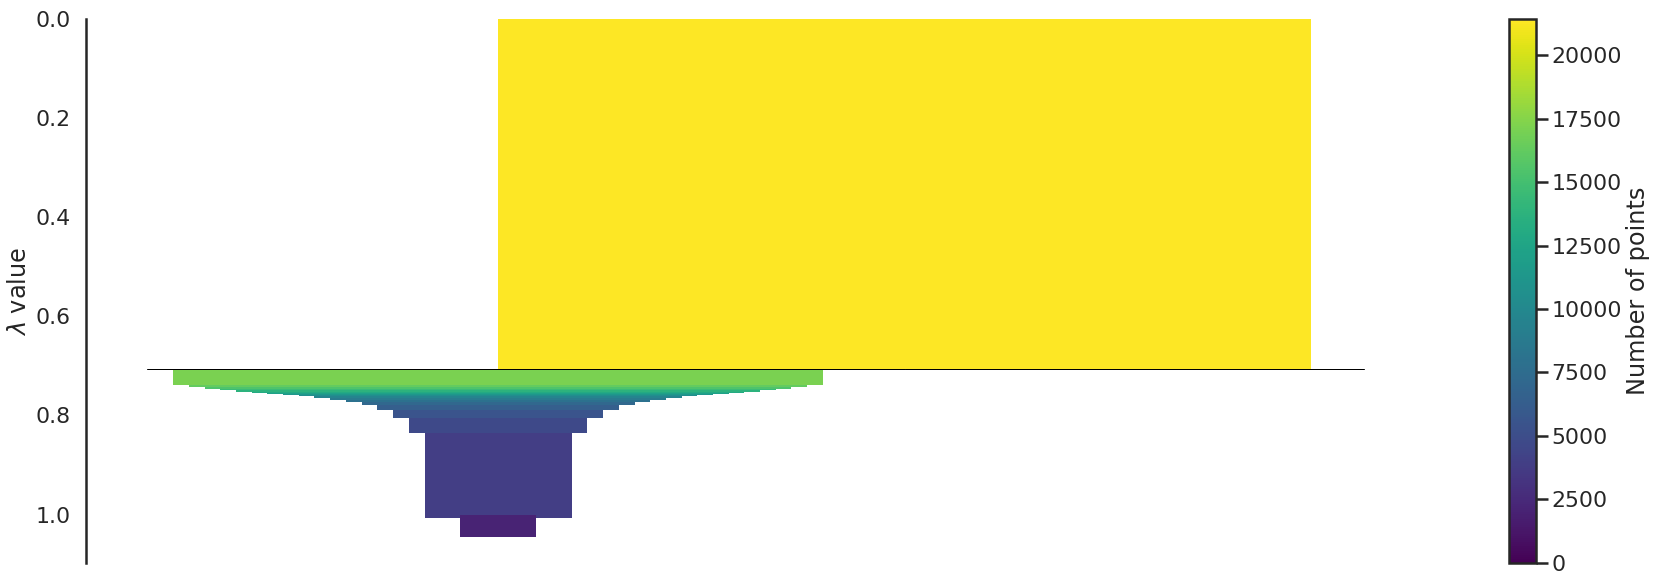

In [54]:
plt.figure(figsize=(30,10))
clusterer.condensed_tree_.plot()

One cluster...???

In [59]:
clusterer_2 = hdbscan.HDBSCAN(min_cluster_size = 1000, gen_min_span_tree = True)
clusterer_2.fit(df_tfidf)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=1000, min_samples=None, p=None,
    prediction_data=False)

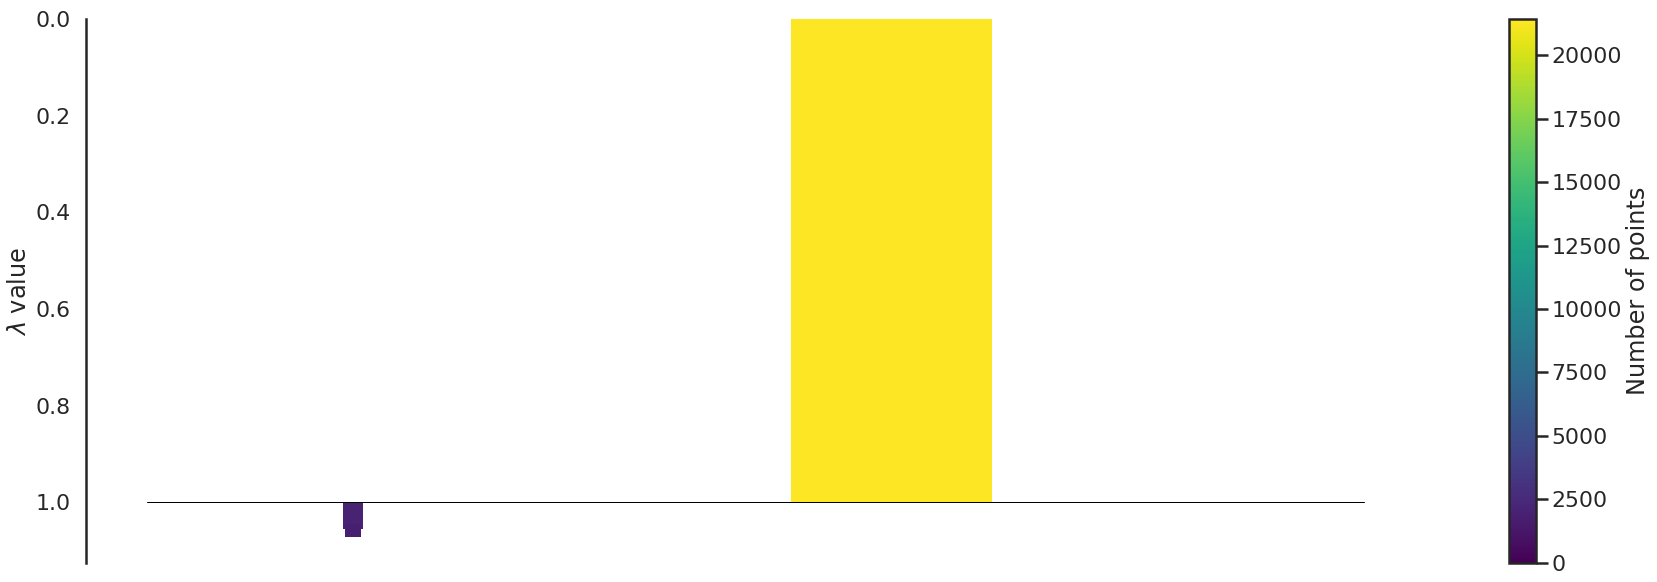

In [60]:
plt.figure(figsize=(30,10))
clusterer_2.condensed_tree_.plot()

In [61]:
clusterer_3 = hdbscan.HDBSCAN(min_cluster_size = 200, gen_min_span_tree = True)
clusterer_3.fit(df_tfidf)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=200, min_samples=None, p=None,
    prediction_data=False)

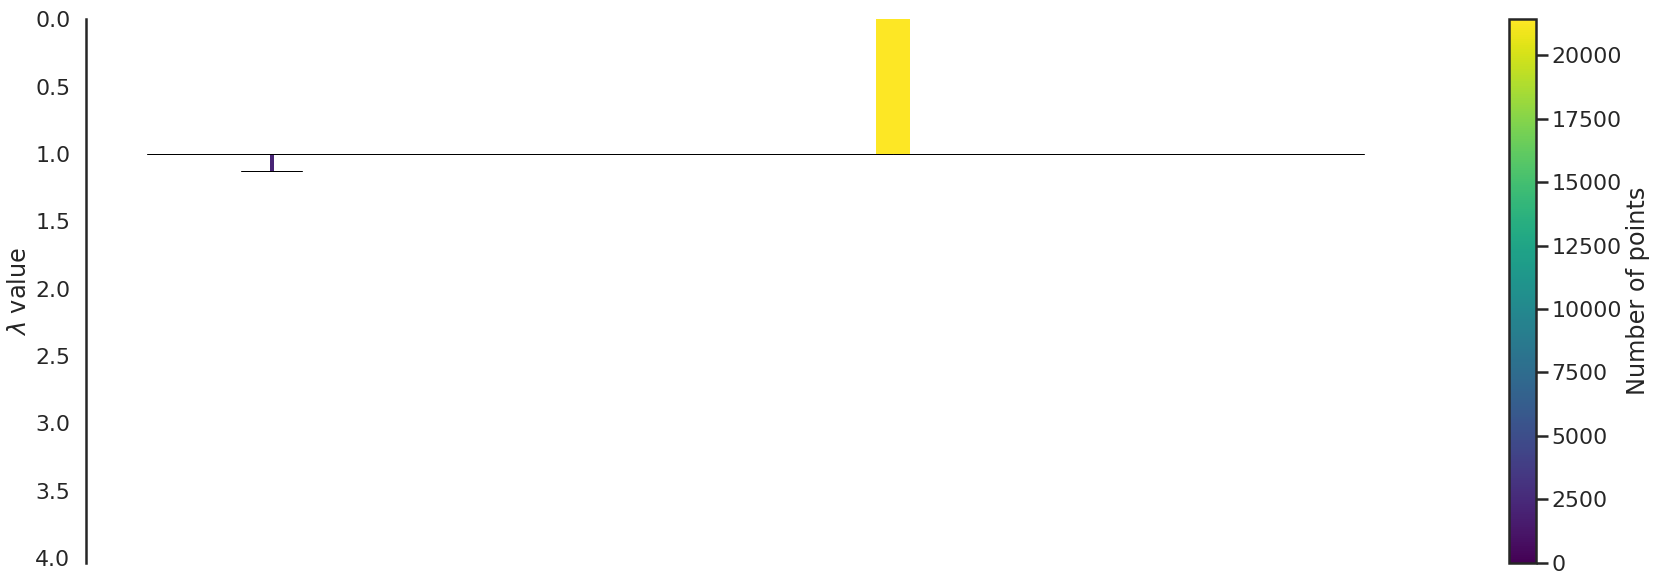

In [62]:
plt.figure(figsize=(30,10))
clusterer_3.condensed_tree_.plot()

In [63]:
clusterer_4 = hdbscan.HDBSCAN(min_cluster_size = 500, gen_min_span_tree = True)
clusterer_4.fit(df_tfidf)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=500, min_samples=None, p=None,
    prediction_data=False)

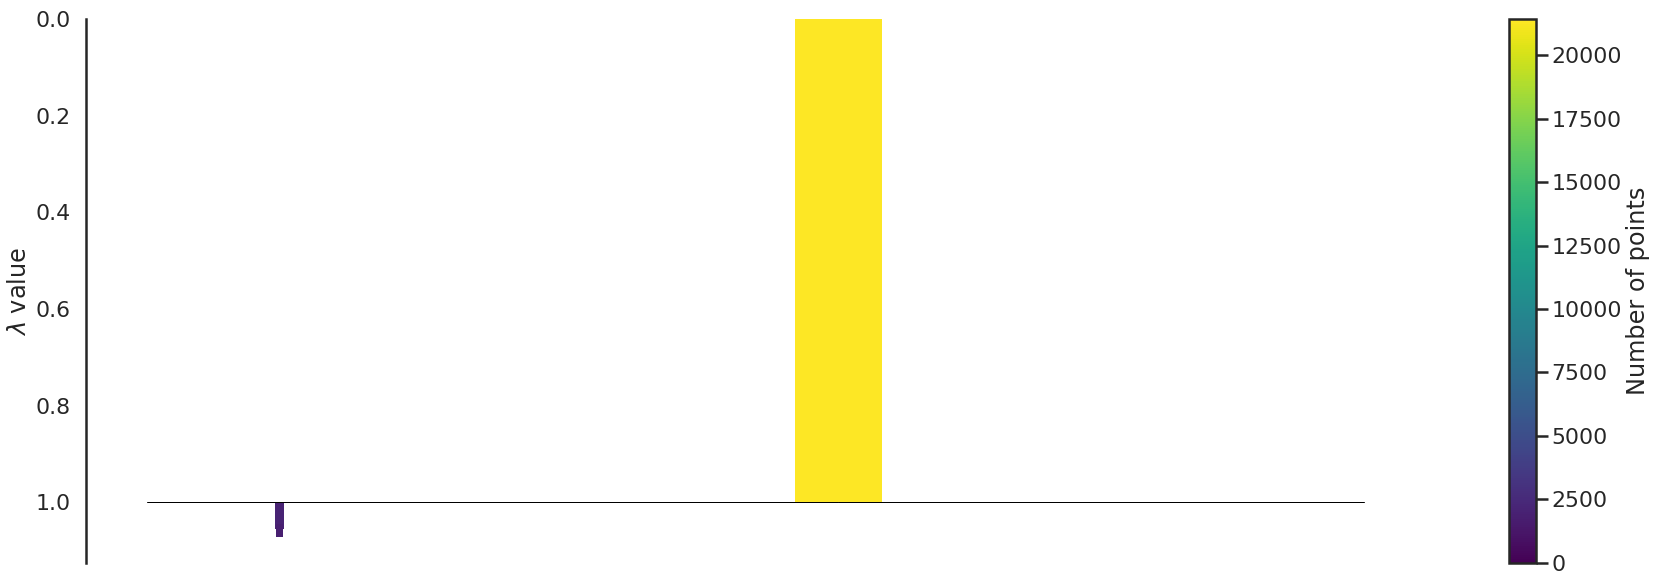

In [64]:
plt.figure(figsize=(30,10))
clusterer_4.condensed_tree_.plot()

In [65]:
clusterer_5 = hdbscan.HDBSCAN(min_cluster_size = 20, gen_min_span_tree = True)
clusterer_5.fit(df_tfidf)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
    prediction_data=False)

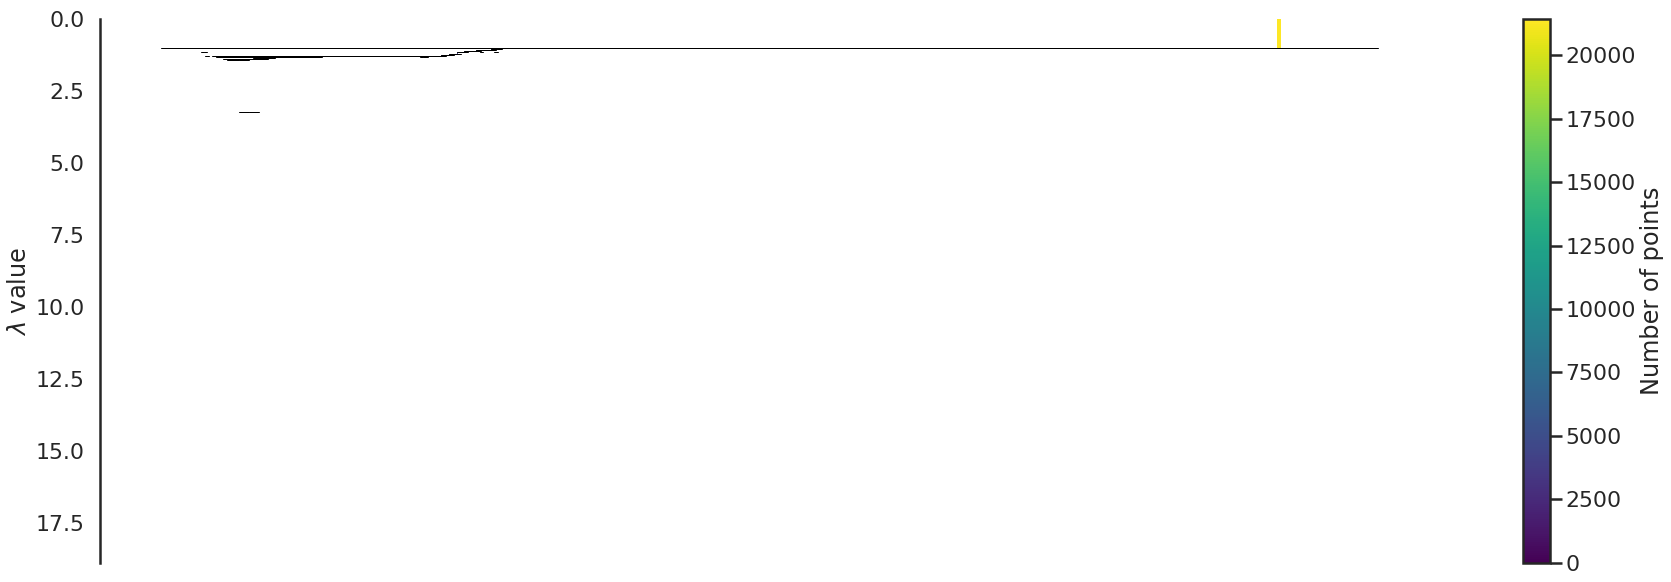

In [66]:
plt.figure(figsize=(30,10))
clusterer_5.condensed_tree_.plot()

In [67]:
clusterer_6 = hdbscan.HDBSCAN(min_cluster_size = 75, gen_min_span_tree = True)
clusterer_6.fit(df_tfidf)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=75, min_samples=None, p=None,
    prediction_data=False)

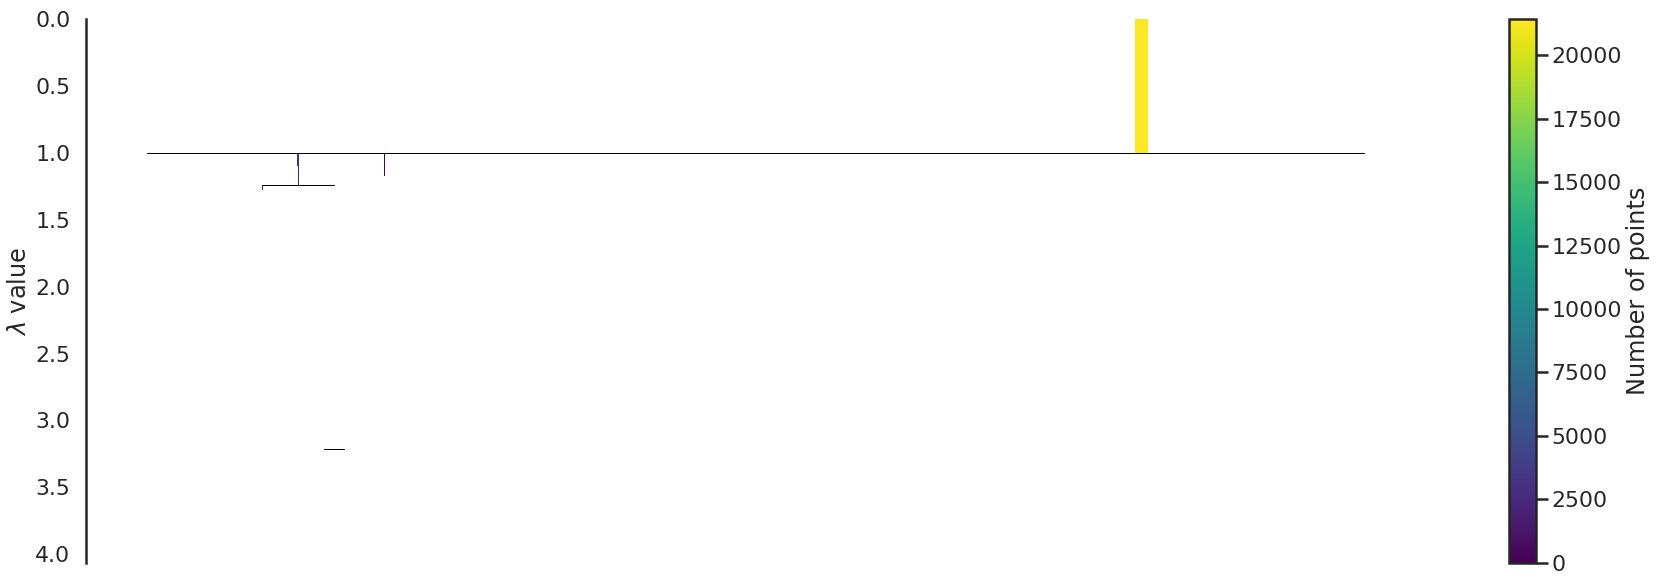

In [68]:
plt.figure(figsize=(30,10))
clusterer_6.condensed_tree_.plot()

Pickle your model if it is one you like!

Python pickle module is used for serializing and de-serializing a Python object structure. Any object in Python can be pickled so that it can be saved on disk; Pickling is a way to convert a python object (list, dict, etc.) into a character stream; The idea is that this character stream contains all the information necessary to reconstruct the object in another python script.

In [ ]:
import pickle

In [ ]:
with open('./clusterer_n.pkl', 'wb+') as f:
    pickle.dump(clusterer_n, f)
##need to .close?

Assets 같은곳에 원하는 모델이 .pkl 로 save 해진다...

In [ ]:
with open('./clusterer_n.pkl', 'rb') as f:
    clusterer_n = pickle.load(f)

In [56]:
# plt.figure(figsize=(20,10))
# clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

In [57]:
plt.figure(figsize=(20,10)) 
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

##creates clusters pretty early but we don't have to lose entire cluster when a few points wants to join others later down the road???

AttributeError: No minimum spanning tree was generated.This may be due to optimized algorithm variations that skip explicit generation of the spanning tree.

<Figure size 1440x720 with 0 Axes>

Visually represent cluster hierarchy:

In [ ]:
plt.figure(figsize=(20,10))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Condensing the plot:

In [ ]:
plt.figure(figsize=(20,10))
clusterer.condensed_tree_.plot()

### SVD

In [87]:
# from sklearn.decomposition import TruncatedSVD
# from sklearn.metrics.pairwise import cosine_similarity

In [88]:
# SVD = TruncatedSVD(n_components=1000) 
# #doesn't center out data...versus PCA which it does...
# ##If we didn't fit before train_test_split (WHY DO WE NEED TO FIT TRANSFORM BEFORE TRAIN TEST SPLIT...)
# svd_matrix = SVD.fit_transform(df_tfidf)
# svd_matrix.shape

### Using spaCy

In [71]:
# ! pip install -U spacy

In [85]:
! python -m spacy download en_core_web_sm

/opt/conda/bin/python: No module named spacy


In [6]:
! pip install -U spacy

  Using cached https://files.pythonhosted.org/packages/ae/6e/a89da6b5c83f8811e46e3a9270c1aed90e9b9ee6c60faf52b7239e5d3d69/spacy-2.0.18-cp36-cp36m-manylinux1_x86_64.whl
Killed


In [92]:
# import spacy

In [3]:
# import spacy
# nlp = spacy.load('en_core_web_sm')
# punctuations = string.punctuation

# #Function to clean up text
# def cleanup_text(docs, logging=False):
#     texts = []
#     counter = 1
#     for doc in docs:
#         if counter % 1000 == 0 and logging:
#             print("Processed %d out of %d documents." % (counter, len(docs)))
#         counter += 1
#         doc = nlp(doc, disable=['parser', 'ner']) #disabling default models of spacy
#         tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']  #Applyint tokenizing and lemmatizing
#         tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations] #Removing stopwords and punctuations
#         tokens = ' '.join(tokens) 
#         texts.append(tokens)  #Appending clean titles to texts list
#     return pd.Series(texts)   #Returning texts list as pd Series

# tweets_clean= cleanup_text(lemm_clean_processed_list)
# tweets_clean = ' '.join(lemm_clean_processed_list).split()

# tweets_counts = Counter(tweets_clean)

# tweets_common_words = [word[0] for word in tweets_counts.most_common(20)]
# tweets_common_counts = [word[1] for word in tweets_counts.most_common(20)]
# fig = plt.figure(figsize=(18,6))
# sns.barplot(x=tweets_common_words, y=tweets_common_counts, palette = "GnBu_d")
# sns.set(font_scale=1.5, rc={'figure.figsize':(8, 8)})
# plt.title('Most Common Words used in tweets')
# plt.show()

ModuleNotFoundError: No module named 'spacy'